In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import codecs
import matplotlib.pyplot as plt
import math

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

# copy the downloaded dataset to the current directory
import shutil
shutil.copytree(path, "dataset", dirs_exist_ok=True)


Path to dataset files: /home/ahmedayman4a/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1


'dataset'

In [3]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return np.array(parsed, dtype=np.uint8).reshape(length)


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return np.array(parsed, dtype=np.uint8).reshape((length,num_rows,num_cols))

In [4]:
train_images = read_image_file('dataset/train-images.idx3-ubyte')
train_labels = read_label_file('dataset/train-labels.idx1-ubyte')
test_images = read_image_file('dataset/t10k-images.idx3-ubyte')
test_labels = read_label_file('dataset/t10k-labels.idx1-ubyte')

print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [5]:
# concat train and test
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])

In [6]:
from sklearn.model_selection import train_test_split
train_test_images, val_images, train_test_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(train_test_images, train_test_labels, test_size=0.2, random_state=42)

In [7]:
print(train_images.shape, train_labels.shape)

(44800, 28, 28) (44800,)


In [8]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [9]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, image_transform:Compose = None):
        self.images = images
        self.labels = labels
        self.image_transform = image_transform

    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image, mode='L')
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, label
        
    def __len__(self):
        return len(self.images)

In [10]:
image_transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

In [11]:
from torchvision.transforms import (
    RandomAffine,
    GaussianBlur,
    ElasticTransform
)

image_augmentation_transform = Compose([
    ToTensor(),
    RandomAffine(
        degrees=7.5,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5,
    ),
    GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)),
    ElasticTransform(alpha=37.0, sigma=5.0),
    Normalize((0.1307,), (0.3081,))
])

In [12]:
train_dataset = MNISTDataset(train_images, train_labels, image_transform)
train_augmented_dataset = MNISTDataset(train_images, train_labels, image_augmentation_transform)
val_dataset = MNISTDataset(val_images, val_labels, image_transform)
test_dataset = MNISTDataset(test_images, test_labels, image_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8, prefetch_factor=8, shuffle=True)
train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=64, num_workers=8, prefetch_factor=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=8, prefetch_factor=8)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=8, prefetch_factor=8)

In [14]:
def visualize_batch(loader):
    batch_images, batch_labels = next(iter(loader))
    print(batch_images.size(), batch_labels.size())
    batch_size = batch_images.size(0)
    cols = math.ceil(math.sqrt(batch_size))
    rows = math.ceil(batch_size / cols)
    # Create a grid of images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
        ax = axes[i//rows, i%cols]
        # Convert tensor back to image for display
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {label.item()}')
    plt.tight_layout()
    plt.show()

torch.Size([64, 1, 28, 28]) torch.Size([64])


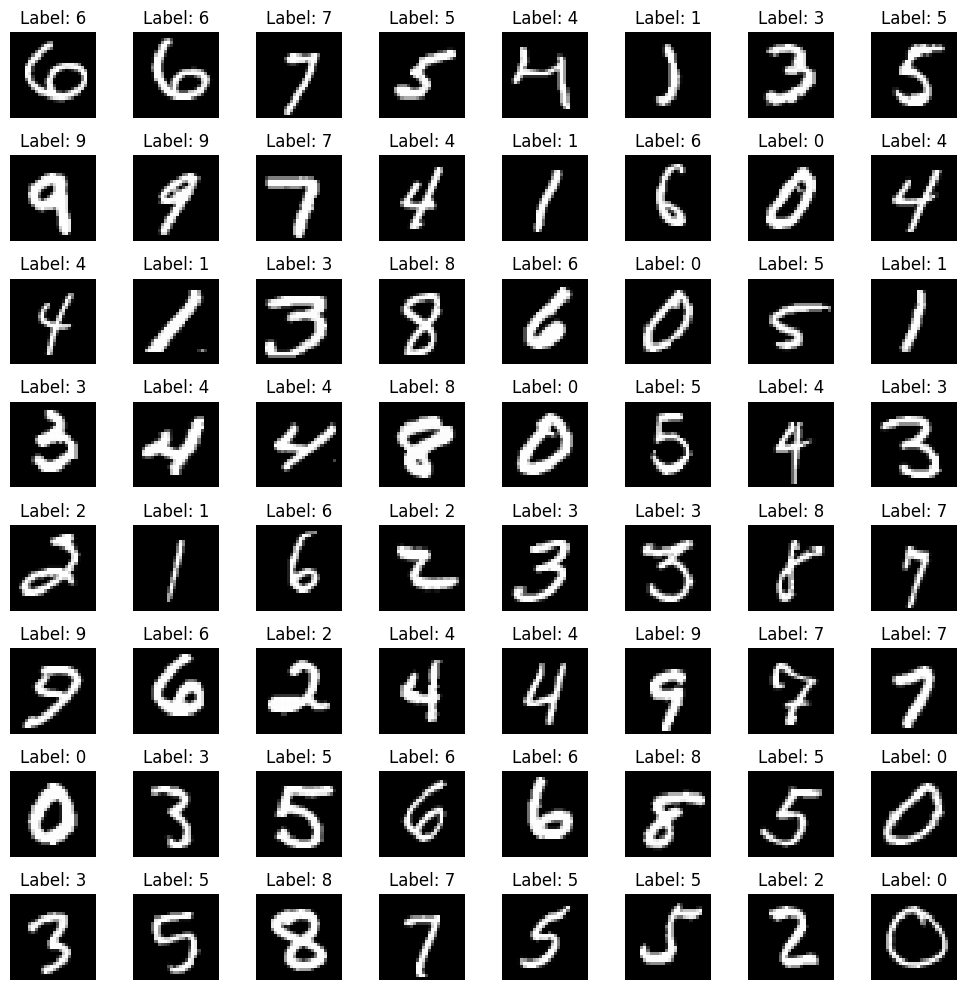

In [15]:
visualize_batch(train_loader)

# Softmax Regression Model

In [16]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class TrainingConfig:
    # Model parameters
    input_size: int = 28 * 28
    output_size: int = 10
    hidden_sizes: List[int] = field(default_factory=lambda: [])  # Empty by default for softmax
    dropout_rate: float = 0.0
    
    # Training parameters
    batch_size: int = 64
    num_epochs: int = 10
    learning_rate: float = 0.01
    weight_decay: float = 0.0
    
    # Optimizer parameters
    optimizer: str = "sgd"  # "sgd", "adam"
    
    # LR scheduler parameters
    scheduler_type: str = "none"  # "none", "cosine", "warmup_cosine"
    warmup_epochs: int = 5
    min_lr: float = 1e-5
    
    # Early stopping parameters
    early_stopping: bool = True
    patience: int = 10
    loss_delta: float = 0.02
    
    # DataLoader parameters
    num_workers: int = 8
    prefetch_factor: int = 2
    use_augmentation: bool = False
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Experiment name
    experiment_name: str = "mnist_experiment"
    project_name: str = "mnist-experiments"

In [17]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.0):
        super(SoftmaxRegression, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size) # remove the channel dimension, flatten the image
        x = self.dropout(x)
        return self.linear(x)

In [18]:
class DeepBigSimpleNet(torch.nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[2500, 2000, 1500], num_classes=10, dropout_rate=0.5):
        super(DeepBigSimpleNet, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        
        # Create layers list
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_sizes[0]))
        layers.append(torch.nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(dropout_rate))
        
        # Hidden layers with decreasing sizes
        for i in range(len(hidden_sizes) - 1):
            layers.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(torch.nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(torch.nn.Linear(hidden_sizes[-1], num_classes))
        
        self.model = torch.nn.Sequential(*layers)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm1d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        return self.model(x)

In [19]:
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm
from tabulate import tabulate
import wandb
from time import time

In [20]:
wandb.login(key="d8ff0fac98c036a4ac0587814c4fd1a2e60f2512")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmedayman4a77. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ahmedayman4a/.netrc


True

In [21]:
import wandb
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class WandBLogger:
    def __init__(self, config):
        self.run = wandb.init(
            project=config.project_name,
            name=config.experiment_name,
            config=config.__dict__,
        )
        
    def log_model_graph(self, model, loss):
        wandb.watch(model, criterion=loss, log="all", log_freq=100)
        
    def log_batch_predictions(self, images, labels, predictions, step):
        # Log sample predictions
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(16):
            i, j = idx//4, idx%4
            ax[i,j].imshow(images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {predictions[idx]}\nTrue: {labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"predictions": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_confusion_matrix(self, true_labels, predictions, step):
        cm = confusion_matrix(true_labels, predictions)
        fig = plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad and p.grad is not None:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean().item())
        fig = plt.figure(figsize=(10, 5))
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.title("Gradient Flow")
        wandb.log({"grad_flow": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_misclassified(self, images, labels, predictions, step):
        mask = predictions != labels
        if not mask.any():
            return
            
        misclassified_images = images[mask][:16]
        misclassified_labels = labels[mask][:16]
        misclassified_preds = predictions[mask][:16]
        
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(min(16, len(misclassified_images))):
            i, j = idx//4, idx%4
            ax[i,j].imshow(misclassified_images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {misclassified_preds[idx]}\nTrue: {misclassified_labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"misclassified": wandb.Image(fig)}, commit=False)
        plt.close()

In [22]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [23]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

class Evaluator:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        
    def __call__(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        inference_times = []
        
        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                start_time = time()
                outputs = self.model(images)
                inference_times.append(time() - start_time)
                
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                
        metrics = self.compute_metrics(all_labels, all_preds, inference_times)
        return metrics
    
    def compute_metrics(self, labels, preds, times):
        
        return {
            'accuracy': (np.array(labels) == np.array(preds)).mean(),
            'confusion_matrix': confusion_matrix(labels, preds),
            'avg_inference_time': np.mean(times),
            'std_inference_time': np.std(times)
        }

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

class ExperimentTracker:
    def __init__(self):
        self.experiment_metrics = {}  # Store per-epoch metrics
        self.experiment_summaries = []  # Store final results
        
    def log_epoch(self, experiment_name: str, epoch_metrics: Dict):
        if experiment_name not in self.experiment_metrics:
            self.experiment_metrics[experiment_name] = []
        self.experiment_metrics[experiment_name].append(epoch_metrics)
    
    def log_summary(self, experiment_name: str, summary_metrics: Dict):
        summary_metrics['experiment_name'] = experiment_name
        self.experiment_summaries.append(summary_metrics)
    
    def get_experiment_df(self, experiment_name: str) -> pd.DataFrame:
        return pd.DataFrame(self.experiment_metrics[experiment_name])
    
    def get_all_summaries(self) -> pd.DataFrame:
        return pd.DataFrame(self.experiment_summaries)
    
    def plot_training_curves(self, metric: str = 'loss'):
        plt.figure(figsize=(12, 6))
        for exp_name, metrics in self.experiment_metrics.items():
            df = pd.DataFrame(metrics)
            plt.plot(df['epoch'], df[f'train_{metric}'], label=f'{exp_name} (train)')
            plt.plot(df['epoch'], df[f'val_{metric}'], label=f'{exp_name} (val)')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()} Curves')
        plt.legend()
        plt.grid(True)
        return plt.gcf()
    
    def plot_confusion_matrix(self, experiment_name: str):
        summary_df = self.get_all_summaries()
        cm = summary_df[summary_df['experiment_name'] == experiment_name]['confusion_matrix'].values[0]
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Confusion Matrix for {experiment_name}')
        return plt.gcf()
    
    def plot_experiment_comparison(self, metric: str):
        summary_df = self.get_all_summaries()
        plt.figure(figsize=(10, 6))
        sns.barplot(data=summary_df, x='experiment_name', y=metric)
        plt.xticks(rotation=45)
        plt.title(f'Comparison of {metric} across experiments')
        return plt.gcf()

In [25]:
class TrainingManager:
    def __init__(self, config: TrainingConfig, tracker: ExperimentTracker):
        self.config = config
        self.logger = WandBLogger(config)
        self.tracker = tracker
        if self.config.early_stopping:
            self.early_stopper = EarlyStopper(patience=self.config.patience, min_delta=self.config.loss_delta)
        else:
            self.early_stopper = None
        
    def get_scheduler(self, optimizer):
        if self.config.scheduler_type == "none":
            return None
        elif self.config.scheduler_type == "cosine":
            return torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max=self.config.num_epochs, 
                eta_min=self.config.min_lr
            )
        elif self.config.scheduler_type == "warmup_cosine":
            warmup_scheduler = LinearLR(optimizer, total_iters=self.config.warmup_epochs)
            main_scheduler = CosineAnnealingLR(optimizer, T_max=self.config.num_epochs - self.config.warmup_epochs, eta_min=self.config.min_lr)
            scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[self.config.warmup_epochs])
            return scheduler
    
    def train(self, model, train_loader, val_loader, test_loader):
        model = model.to(self.config.device)
        if self.config.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=self.config.learning_rate,
                weight_decay=self.config.weight_decay
            )
        elif self.config.optimizer == "adam":
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=self.config.learning_rate,
                weight_decay=self.config.weight_decay
            )
        else:
            raise ValueError("Invalid optimizer type")
        
        scheduler = self.get_scheduler(optimizer)
        criterion = CrossEntropyLoss()
        self.logger.log_model_graph(model, criterion)
        
        
        start_time = time()
        for epoch in range(self.config.num_epochs):
            epoch_start = time()
            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            train_acc = 100. * correct / total
            train_loss = train_loss / len(train_loader)
            
            # Validation
            val_loss, val_acc = self.validate(model, val_loader, criterion, epoch)
            
            # Update scheduler
            if scheduler is not None:
                scheduler.step()
            
            epoch_time = time() - epoch_start
            
            epoch_metrics = { 
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr'],
                'epoch_time': epoch_time,
            }
            # Log metrics
            self.tracker.log_epoch(self.config.experiment_name, epoch_metrics)
            wandb.log(epoch_metrics)
            
            
            if self.early_stopper is not None and self.early_stopper(val_loss):
                print(f"Early stopping triggered at epoch {epoch}")
                break
            
        total_time = time() - start_time
        
        # Final evaluation
        evaluate = Evaluator(model, test_loader, self.config.device)
        test_metrics = evaluate()
        test_metrics['total_time'] = total_time
        self.tracker.log_summary(self.config.experiment_name, test_metrics)
        
        
        fig = plt.figure(figsize=(10, 10))
        sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d')
        # Log final metrics
        wandb.log({
            'total_training_time': total_time,
            'test_accuracy': test_metrics['accuracy'],
            'avg_inference_time': test_metrics['avg_inference_time'],
            'test_confusion_matrix': wandb.Image(fig)
        })
        
        wandb.finish()
        return test_metrics
        
    def validate(self, model, val_loader, criterion, epoch):
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_images, val_labels = [], []
        val_preds = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                predictions = outputs.argmax(dim=1)
                total += targets.size(0)
                correct += predictions.eq(targets).sum().item()
                val_images.extend(inputs.cpu())
                val_labels.extend(targets.cpu())
                val_preds.extend(predictions.cpu())
                
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        val_preds = torch.tensor(val_preds)
        
        # Log validation artifacts
        self.logger.log_batch_predictions(
            val_images[:16], 
            val_labels[:16], 
            val_preds[:16], 
            epoch
        )
        self.logger.log_confusion_matrix(
            val_labels, 
            val_preds, 
            epoch
        )
        self.logger.log_misclassified(
            val_images,
            val_labels, 
            val_preds,
            epoch
        )
        self.logger.log_grad_flow(model.named_parameters())
            
        return val_loss / len(val_loader), 100. * correct / total

In [26]:
experiments = [
    # TrainingConfig(learning_rate=1.0, experiment_name="softmax_lr_1.0", early_stopping=False),
    # TrainingConfig(learning_rate=0.01, experiment_name="softmax_lr_0.01"),
    # TrainingConfig(learning_rate=0.00001, experiment_name="softmax_lr_0.00001"),
    # TrainingConfig(
    #     learning_rate=0.01, 
    #     scheduler_type="warmup_cosine",
    #     warmup_epochs=5,
    #     experiment_name="softmax_warmup_cosine"
    # ),
    # TrainingConfig(batch_size=1, experiment_name="softmax_batch_1"),
    # TrainingConfig(batch_size=16, experiment_name="softmax_batch_16"),
    # TrainingConfig(batch_size=256, experiment_name="softmax_batch_256"),
    # TrainingConfig(
    #     learning_rate=0.01,
    #     weight_decay=0.01,
    #     dropout_rate=0.1,
    #     experiment_name="softmax_with_regularization"
    # ),
     # DeepBigSimpleNet experiments
    TrainingConfig(
        input_size=28 * 28,
        output_size=10,
        hidden_sizes=[40, 15],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        experiment_name="deep_net_nano"
    ),
    TrainingConfig(
        input_size=28 * 28, 
        output_size=10,
        hidden_sizes=[1500, 1000, 500],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        optimizer="adam",
        use_augmentation=True,
        experiment_name="deep_net_medium"
    ),
    TrainingConfig(
        input_size=28 * 28,
        output_size=10, 
        hidden_sizes=[2500, 2000, 1500, 1000, 500],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        optimizer="adam",
        use_augmentation=True,
        experiment_name="deep_net_large"
    )
]

In [27]:
def run_experiments(experiments, tracker=None):
    if tracker is None:
        tracker = ExperimentTracker()
        
    for config in experiments:
        print(f"Running experiment: {config.experiment_name}")
        
        chose_train_dataset = train_augmented_dataset if config.use_augmentation else train_dataset
        # Create data loaders
        train_loader = DataLoader(
            chose_train_dataset, 
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor,
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor
        )
        
        # Create appropriate model based on config
        if len(config.hidden_sizes) > 0:
            # Use DeepBigSimpleNet if hidden_sizes are specified
            model = DeepBigSimpleNet(
                input_size=config.input_size,
                hidden_sizes=config.hidden_sizes,
                num_classes=config.output_size,
                dropout_rate=config.dropout_rate
            )
        else:
            # Use SoftmaxRegression for basic experiments
            model = SoftmaxRegression(
                input_size=config.input_size,
                output_size=config.output_size,
                dropout_rate=config.dropout_rate
            )
        
        trainer = TrainingManager(config, tracker)
        trainer.train(model, train_loader, val_loader, test_loader)

Running experiment: deep_net_nano


/home/ahmedayman4a/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,█▃▄▂▂▁▄▄▁▅
learning_rate,▄▅▆▇█▇▆▃▂▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▄▆▇▇█████
train_loss,█▆▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▆▄▃▂▂▁▁▁▁
avg_inference_time,0.00098


Running experiment: deep_net_medium


/home/ahmedayman4a/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▃▄▃▃▅▃▃▅█
learning_rate,▄▅▆▇█▇▆▃▂▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▃▂▂▁▁▁▁
avg_inference_time,0.0122


Running experiment: deep_net_large


/home/ahmedayman4a/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time,▁▃▆▆█▅▅▃▄▄
learning_rate,▄▅▆▇█▇▆▃▂▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▄▅▆▇▇████
train_loss,█▅▄▃▂▂▁▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
avg_inference_time,0.03602


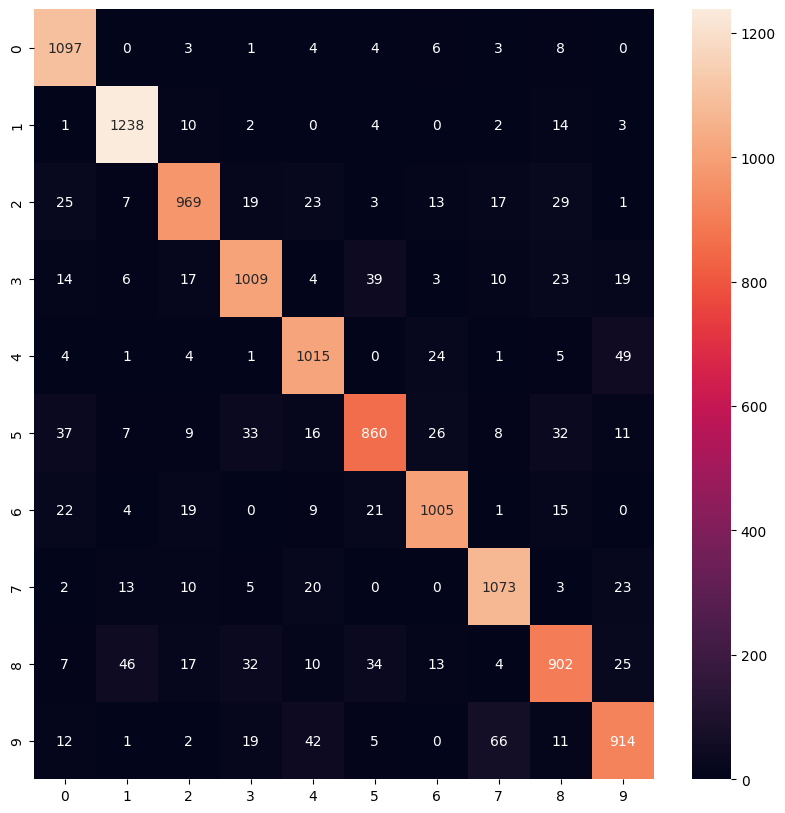

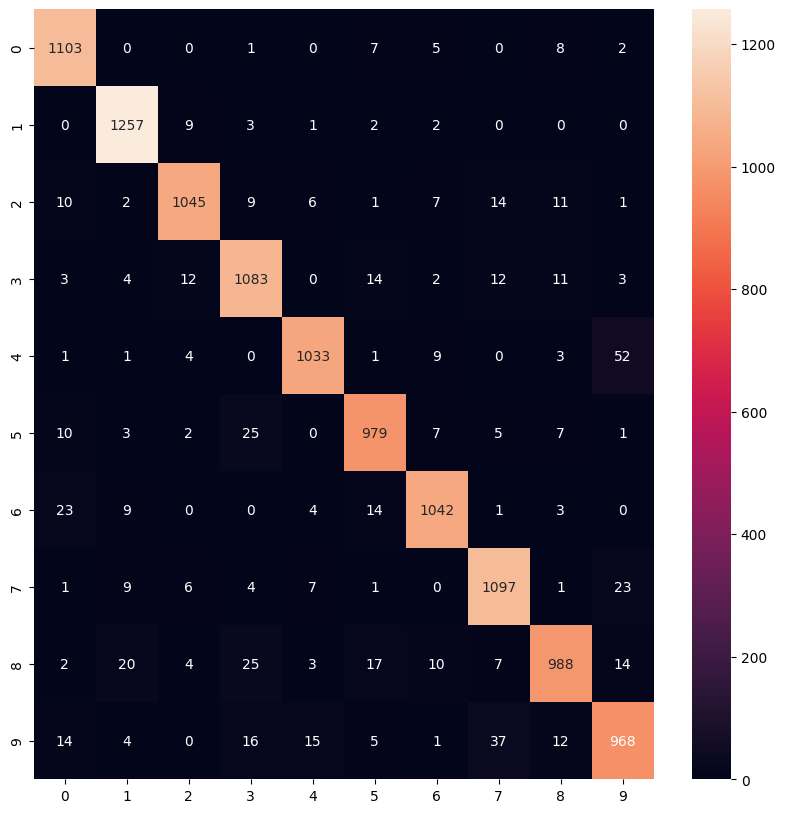

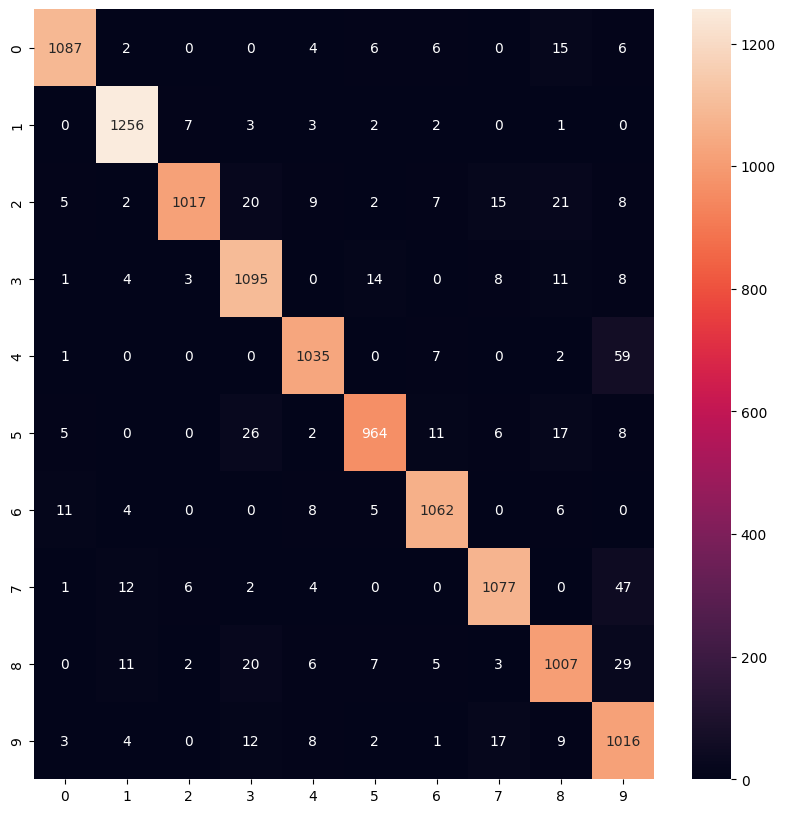

In [28]:
tracker = ExperimentTracker()
run_experiments(experiments, tracker)

In [29]:
# Display summary table
summary_df = tracker.get_all_summaries()
# remove confusion matrix from summary
display(summary_df.drop(columns=['confusion_matrix']).style.highlight_max(subset=['accuracy']))

,accuracy,avg_inference_time,std_inference_time,experiment_name
0,0.900179,0.000983,0.001878,deep_net_nano
1,0.945982,0.012203,0.003166,deep_net_medium
2,0.947857,0.036019,0.005374,deep_net_large


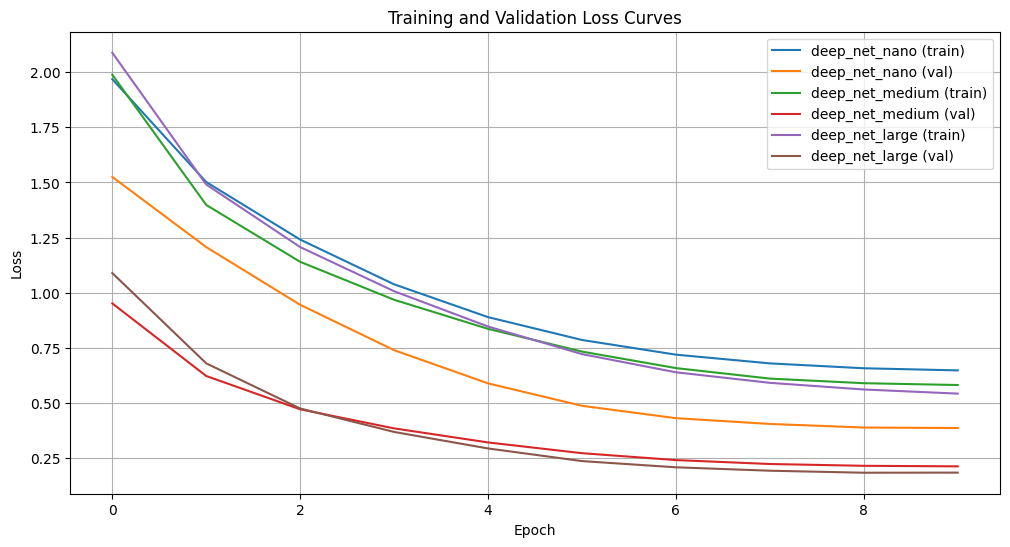

In [30]:
# Plot training curves
fig = tracker.plot_training_curves('loss')
plt.show()

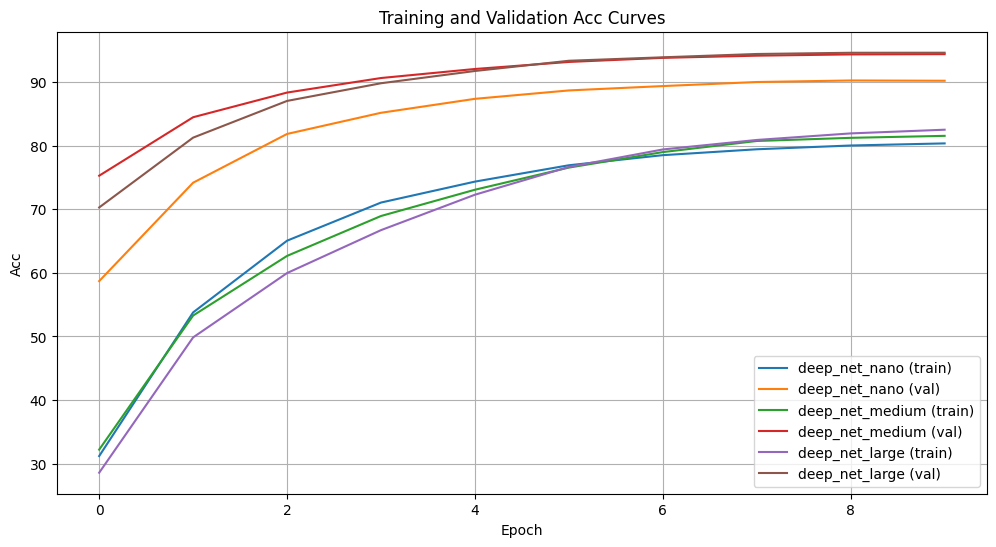

In [31]:
fig = tracker.plot_training_curves('acc')
plt.show()

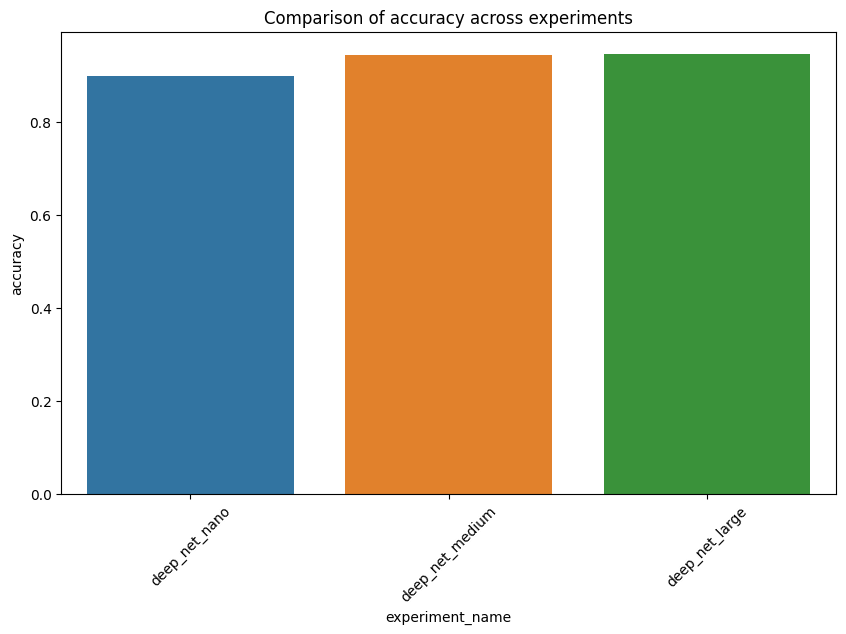

In [32]:
# Compare final metrics on test set
fig = tracker.plot_experiment_comparison('accuracy')
plt.show()

In [33]:
# Export results
summary_df.to_csv('experiment_results.csv')

In [34]:
# Detailed view of specific experiment
exp_df = tracker.get_experiment_df('deep_net_large')
display(exp_df)

,epoch,train_loss,train_acc,val_loss,val_acc,learning_rate,epoch_time
0,0,2.087906,28.573661,1.088949,70.278571,0.004667,68.290399
1,1,1.490416,49.848214,0.679568,81.257143,0.006000,70.046013
2,2,1.206727,59.964286,0.474840,87.028571,0.007333,72.413378
3,3,1.006603,66.712054,0.368628,89.807143,0.008667,72.322136
4,4,0.846557,72.281250,0.293715,91.735714,0.010000,74.229865
5,5,0.721500,76.649554,0.236442,93.342857,0.009046,71.941048
6,6,0.639046,79.397321,0.208273,93.885714,0.006549,71.969714
7,7,0.591219,80.890625,0.192775,94.407143,0.003461,70.195666
8,8,0.561047,81.921875,0.183706,94.600000,0.000964,71.190271
9,9,0.542432,82.502232,0.184213,94.607143,0.000010,70.457550


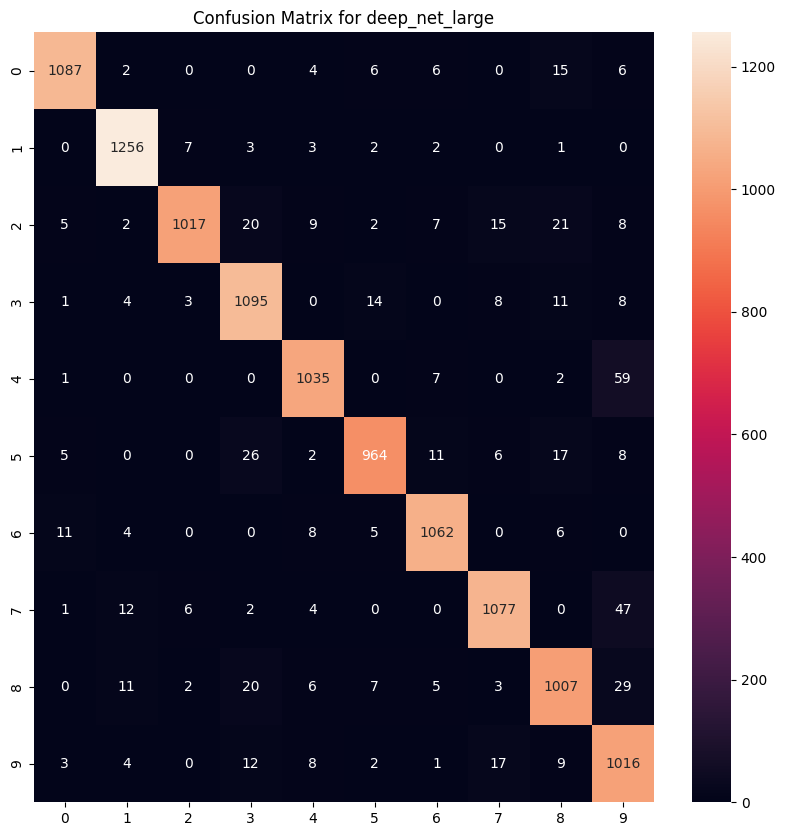

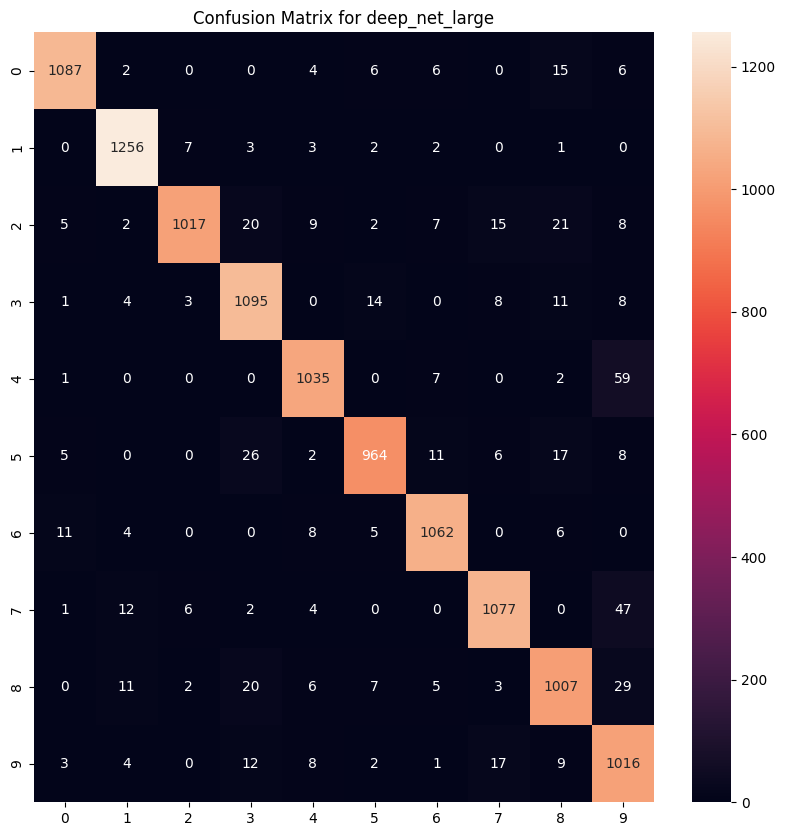

In [35]:
tracker.plot_confusion_matrix('deep_net_large')